### Step 1 - Imports & parameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Typical rate-1/2, constraint length K=3 code with generators (in binary):
# g1 = 111 (octal 7), g2 = 101 (octal 5)
g1 = 0b111
g2 = 0b101
K = 3 # constraint length
rng = np.random.default_rng(0)

### Step 2 - Convolutional encoder (rate 1/2)
Shift the input bit into a K-bit register and output two parity bits y1, y2 formed by modulo-2 dot-
products with the generator polynomials.

In [3]:
def conv_encode(bits, g1=0b111, g2=0b101, K=3):
    state = 0
    mask = (1 << K) - 1
    out = []
    for b in bits:
        state = ((state << 1) | int(b)) & mask
        y1 = bin(state & g1).count('1') % 2
        y2 = bin(state & g2).count('1') % 2
        out.extend([y1, y2])
    return np.array(out, dtype=int)

# smoke test
msg = rng.integers(0,2,size=16)
enc = conv_encode(msg, g1, g2, K)
print("encoded length =", len(enc), "(should be 2*len(msg))")

encoded length = 32 (should be 2*len(msg))


### Step 3 - BSC channel

In [4]:
def bsc(bits, e, rng=None):
    rng = np.random.default_rng(rng)
    flips = (rng.random(len(bits)) < e).astype(int)
    return bits ^ flips

### Step 4 - Viterbi decoder (hard decision)
We construct a trellis with 2^(K−1) states. For each input bit (0 or 1), compute the next state and
the expected 2-bit encoder output; update path metrics using Hamming distance to the received
pair, and keep best predecessors. Backtrack at the end.

In [8]:
def viterbi_decode(received, g1=0b111, g2=0b101, K=3):
    # received: 1D array of length 2*n (two coded bits per input bit)
    n = len(received) // 2
    S = 1 << (K - 1) # number of states
    INF = 10**9
    
    # Precompute next-state and outputs for each state and input bit
    mask = (1 << K) - 1
    next_state = np.zeros((S,2), dtype=int) # [state, input_bit] -> next_state
    out_bits = np.zeros((S,2,2), dtype=int) # expected output pair
    
    for s in range(S):
        for b in (0,1):
            full = ((s << 1) | b) & mask
            ns = full & (S-1) # keep lower K-1 bits as new state
            y1 = bin(full & g1).count('1') % 2
            y2 = bin(full & g2).count('1') % 2
            next_state[s,b] = ns
            out_bits[s,b] = (y1, y2)
                
    # DP tables
    pm = np.full((n+1, S), INF, dtype=int) # path metric
    prev_s = np.full((n+1, S), -1, dtype=int)
    prev_b = np.full((n+1, S), -1, dtype=int)
    pm[0,0] = 0 # start from state 0 (all-zero shift-register)
        
    # Forward pass
    for t in range(n):
        r = received[2*t:2*t+2]
        for s in range(S):
            if pm[t, s] >= INF:
                continue
            for b in (0,1):
                ns = next_state[s,b]
                y = out_bits[s,b]
                # Hamming distance between received pair and expected pair
                dist = int(r[0] != y[0]) + int(r[1] != y[1])
                cand = pm[t, s] + dist
                if cand < pm[t+1, ns]:
                    pm[t+1, ns] = cand
                    prev_s[t+1, ns] = s
                    prev_b[t+1, ns] = b
    
    # Backtrack from best end state
    end_state = int(np.argmin(pm[n]))
    bits = []
    s = end_state
    for t in range(n, 0, -1):
        b = prev_b[t, s]
        bits.append(b)
        s = prev_s[t, s]
    bits.reverse()
    return np.array(bits, dtype=int)

### Step 5 - End-to-end test and BE

In [9]:
def ber(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return np.mean(a != b)

# Quick test
n_bits = 2000
msg = rng.integers(0,2,size=n_bits)
enc = conv_encode(msg, g1, g2, K)
e = 0.1
rx = bsc(enc, e=e, rng=1)
dec = viterbi_decode(rx, g1, g2, K)
print("BER @ e=0.1:", ber(msg, dec))

BER @ e=0.1: 0.06


### Step 6 - Sweep e and plot BER

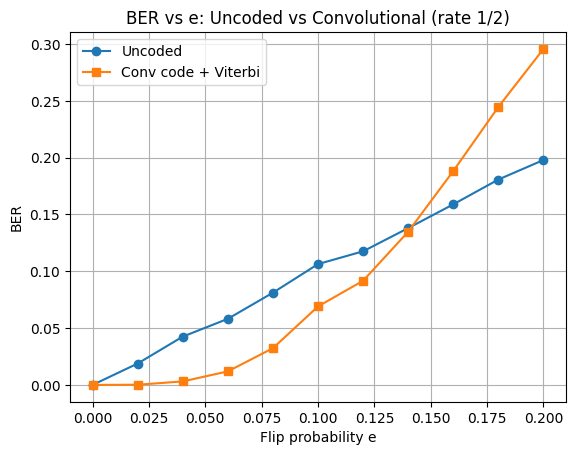

e=0.000 BER_uncoded=0.00000 BER_coded=0.00000 gain=infx
e=0.020 BER_uncoded=0.01883 BER_coded=0.00017 gain=113.00x
e=0.040 BER_uncoded=0.04250 BER_coded=0.00308 gain=13.78x
e=0.060 BER_uncoded=0.05817 BER_coded=0.01192 gain=4.88x
e=0.080 BER_uncoded=0.08117 BER_coded=0.03233 gain=2.51x
e=0.100 BER_uncoded=0.10633 BER_coded=0.06908 gain=1.54x
e=0.120 BER_uncoded=0.11758 BER_coded=0.09167 gain=1.28x
e=0.140 BER_uncoded=0.13800 BER_coded=0.13483 gain=1.02x
e=0.160 BER_uncoded=0.15892 BER_coded=0.18825 gain=0.84x
e=0.180 BER_uncoded=0.18075 BER_coded=0.24467 gain=0.74x
e=0.200 BER_uncoded=0.19792 BER_coded=0.29567 gain=0.67x


In [10]:
def sweep_ber(e_values, n_bits=5000, trials=3, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    ber_uncoded = []
    ber_coded = []
    for e in e_values:
        errs_u = 0; total_u = 0
        errs_c = 0; total_c = 0
        for _ in range(trials):
            msg = rng.integers(0,2,size=n_bits)
            # Uncoded baseline
            rx_u = bsc(msg, e, rng)
            errs_u += np.sum(msg != rx_u); total_u += msg.size
            # Coded
            enc = conv_encode(msg, g1, g2, K)
            rx = bsc(enc, e, rng)
            dec = viterbi_decode(rx, g1, g2, K)
            errs_c += np.sum(msg != dec); total_c += msg.size
        ber_uncoded.append(errs_u/total_u)
        ber_coded.append(errs_c/total_c)
    return np.array(ber_uncoded), np.array(ber_coded)
    
es = np.linspace(0.0, 0.2, 11)
uBER, cBER = sweep_ber(es, n_bits=4000, trials=3, rng_seed=123)

plt.figure()
plt.plot(es, uBER, marker='o', label='Uncoded')
plt.plot(es, cBER, marker='s', label='Conv code + Viterbi')
plt.xlabel('Flip probability e')
plt.ylabel('BER')
plt.title('BER vs e: Uncoded vs Convolutional (rate 1/2)')
plt.grid(True); plt.legend()
plt.show()

for e, bu, bc in zip(es, uBER, cBER):
    gain = (bu/bc) if bc>0 else float('inf')
    print(f"e={e:.3f} BER_uncoded={bu:.5f} BER_coded={bc:.5f} gain={gain:.2f}x")